### 깃허브 이슈 태거 만들기
이슈에 여러 개의 레이블을 할당할 수 있으므로 **다중 레이블 텍스트 분류** 문제

* 데이터 준비하기

In [1]:
import time
import math
import requests
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm

def fetch_issues(owner="huggingface", repo="transformers", num_issues=10_000,
                 rate_limit=5_000):
    batch = []
    all_issues = []
    per_page = 100     # 페이지마다 반환되는 이슈 개수
    num_pages = math.ceil(num_issues / per_page)
    base_url = "https://api.github.com/repos"

    for page in tqdm(range(num_pages)):
        # 오픈 이슈와 클로즈 이슈를 모두 가져오기 위해 state=all로 쿼리합니다.
        query = f"issues?page={page}&per_page={per_page}&state=all"
        issues = requests.get(f"{base_url}/{owner}/{repo}/{query}")
        batch.extend(issues.json())

        if len(batch) > rate_limit and len(all_issues) < num_issues:
            all_issues.extend(batch)
            batch = []   # 다음 번 요청을 위해 비웁니다.
            print(f"깃허브 요청 한도에 도달했습니다. 한 시간 동안 중지합니다...")
            time.sleep(60 * 60 + 1)

    all_issues.extend(batch)
    df = pd.DataFrame.from_records(all_issues)
    df.to_json(f"github-issues-{repo}.jsonl", orient="records", lines=True)

C:\Users\knuyh\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
import pandas as pd

dataset_url = "https://git.io/nlp-with-transformers"
df_issues = pd.read_json(dataset_url, lines=True)
print(f"데이터프레임 크기: {df_issues.shape}")

데이터프레임 크기: (9930, 26)


In [4]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [5]:
df_issues["labels"] = (df_issues["labels"]
                       .apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()
# labels 열에 있는 각 행은 깃허브 레이블의 리스트

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [6]:
df_issues["labels"].apply(lambda x : len(x)).value_counts().to_frame().T

labels,0,1,2,3,4,5
count,6440,3057,305,100,25,3


In [7]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"레이블 개수: {len(df_counts)}")
# 상위 8개 레이블
df_counts.to_frame().head(8).T

레이블 개수: 65


labels,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
count,2284,649,106,98,64,52,50,46


In [8]:
# 클래스 불균형으로 맞춰줌
label_map = {"Core: Tokenization": "tokenization",
             "New model": "new model",
             "Core: Modeling": "model training",
             "Usage": "usage",
             "Core: Pipeline": "pipeline",
             "TensorFlow": "tensorflow or tf",
             "PyTorch": "pytorch",
             "Examples": "examples",
             "Documentation": "documentation"}

def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())

In [9]:
df_counts = df_issues["labels"].explode().value_counts()
df_counts.to_frame().T

labels,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
count,106,98,64,46,42,41,37,28,24


In [10]:
# 이슈에 레이블 유무
df_issues["split"] = "unlabeled"
mask = df_issues["labels"].apply(lambda x: len(x)) > 0
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,count
split,
unlabeled,9489
labeled,441


In [11]:
for column in ["title", "body", "labels"]:
    print(f"{column}: {df_issues[column].iloc[26][:500]}\n")
# 새로운 모델 구조 제안 : new model 태그

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In [12]:
df_issues["text"] = (df_issues
                     .apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1))

In [13]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"삭제된 중복 이슈: {(len_before-len(df_issues))/len_before:.2%}")

삭제된 중복 이슈: 1.88%


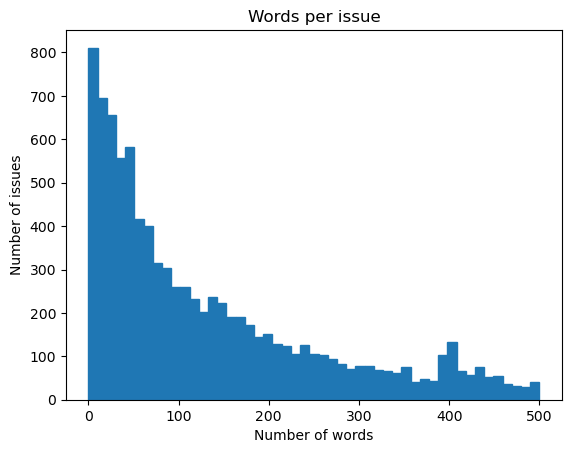

In [14]:
import numpy as np
import matplotlib.pyplot as plt

(df_issues["text"].str.split().apply(len)
 .hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor="C0"))
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

대부분의 텍스트가 매우 짧지만, 500단어가 넘는 이슈도 있다. (에러 메시지나 코드를 함께 포스팅한 경우)  
트랜스포머 모델의 문맥 크기는 512 개 토큰이나 그 이상이기에 일부 긴 이슈를 잘라내는 것이 전체 성능에 영향을 미칠 것 같지 않다.

* 훈련 세트 만들기

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [20]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels,
                                                           test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]

In [21]:
from sklearn.model_selection import train_test_split

df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [22]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})

* 훈련 슬라이스 만들기  

훈련셋은 단 220개 샘플로 매우 적음, 샘플 개수가 더 적은 훈련 데이터의 슬라이스로 만들어 샘플 개수에 대한 성능을 그래프로 그려 성능 확인

In [25]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # 다음 슬라이스 크기를 채우는데 필요한 샘플 분할
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))


train_slices.append(all_indices), train_samples.append(len(ds["train"]))

train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [26]:
print("목표 분할 크기:")
print(train_samples)
print("실제 분할 크기:")
print([len(x) for x in train_slices])

목표 분할 크기:
[8, 16, 32, 64, 128, 223]
실제 분할 크기:
[10, 19, 36, 68, 134, 223]


### 나이브 베이즈 모델 만들기
* 정규 표현식, 수동 규칙 또는 매우 간단한 모델을 기반으로 하는 기준 모델이 실제로 문제를 잘 해결한다. 트랜스포머 같은 모델은 제품 환경에 배포하고 유지 관리가 대체로 더 복잡하다.
* 복잡한 모델을 탐색할 때 기준 모델이 간단한 검증 역할을 한다. BERT-large 모델을 훈련하고 검증셋에서 80% 정확도를 얻었다고 할때, 어려운 데이터셋이라 생각하고 끝낼지도 모른다. 하지만 로지스틱 회귀 같은 간단한 분류기가 95% 정확도 달성했다면, 모델에 버그가 있는지 의심하고 디버깅하게 된다.

<br>

* 텍스트 분류의 경우 좋은 기준점은 나이브 베이즈 분류기이다.
    * 간단하고 훈련 속도가 빠르며 입력의 변동에 매우 안정적

In [27]:
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [28]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

# 단어 순서 정보가 모두 없어짐 : BoW
for train_slice in train_slices:
    # 훈련 슬라이스와 테스트 데이터
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # 간단한 CountVectorizer를 사용해 텍스트를 토큰 카운트로 인코딩
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # 훈련
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # 예측 생성 및 평가
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    # 결과 저장
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

In [30]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run,
                     linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run,
                     linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

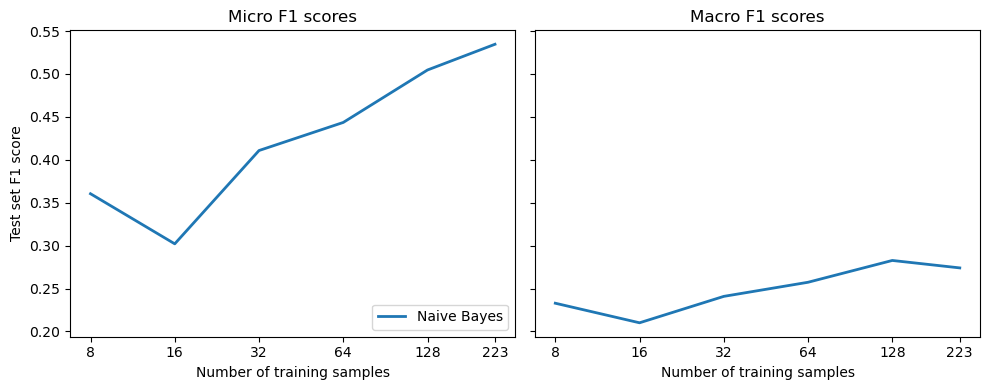

In [31]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

훈련 샘플 개수의 증가에 따라 두 점수 모두 향상

### 레이블이 없는 데이터 다루기
* 레이블링된 데이터가 전혀 없을 때 : 제로샷 분류
    * 작업별 말뭉치에서 추가로 미세 튜닝하지 않고 사전 훈련된 모델을 사용하는 것이 목표

In [32]:
from transformers import pipeline

pipe = pipeline("fill-mask", model="bert-base-uncased")

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\knuyh\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [33]:
movie_desc = "The main characters of the movie madacascar \
are a lion, a zebra, a giraffe, and a hippo. "
prompt = "The movie is about [MASK]."

output = pipe(movie_desc + prompt)
for element in output:
    print(f"토큰 {element['token_str']}:\t{element['score']:.3f}%")
    
# fill-mask 파이프라인은 마스킹된 위치에 놓기에 가장 가능성이 높은 토큰 반환

토큰 animals:	0.103%
토큰 lions:	0.066%
토큰 birds:	0.025%
토큰 love:	0.015%
토큰 hunting:	0.013%


In [34]:
# 가장 가능성이 높은 토큰을 얻는 대신 주어진 토큰에 대한 확률 출력
output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"토큰 {element['token_str']}:\t{element['score']:.3f}%")

토큰 animals:	0.103%
토큰 cars:	0.001%


In [35]:
movie_desc = "In the movie transformers aliens \
can morph into a wide range of vehicles."

output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"토큰 {element['token_str']}:\t{element['score']:.3f}%")    

토큰 cars:	0.139%
토큰 animals:	0.006%


텍스트 함의 : 모델이 두 개의 텍스트 구절이 서로 연결되는지 모순되는지 판단  
각 샘플은 전제(premise) / 가설(hypothesis) / 레이블 으로 구성  

    * 레이블은 entailment / neutral / contradiction
        * entailment : 전제 조건하에서 가설 텍스트가 참일 때 할당
        * contradiction : 전제 조건하에서 가설 텍스트가 거짓이거나 부적합일 때 할당
        * neutral : 두 경우에 해당하지 않을 때 할당

In [36]:
# 제로샷 분류를 위한 MNLI 모델
from transformers import pipeline

pipe = pipeline('zero-shot-classification')

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\knuyh\.cache\huggingface\hub\models--facebook--bart-large-mnli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [37]:
sample = ds["train"][0]
print(f"레이블: {sample['labels']}")
output = pipe(sample["text"], all_labels, multi_label=True) # 단일 레이블 분류를 위한 최댓값이 아닌 모든 점수 반환(multi_label=T)
print(output["sequence"][:400])
print("\n예측:")

for label, score in zip(output["labels"], output["scores"]):
    print(f"{label}, {score:.2f}")

레이블: ['new model']
Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokeni

예측:
new model, 0.98
tensorflow or tf, 0.37
examples, 0.34
usage, 0.30
pytorch, 0.25
documentation, 0.25
model training, 0.24
tokenization, 0.17
pipeline, 0.16


In [38]:
def zero_shot_pipeline(example):
    output = pipe(example["text"], all_labels, multi_label=True)
    example["predicted_labels"] = output["labels"]
    example["scores"] = output["scores"]
    return example

ds_zero_shot = ds["valid"].map(zero_shot_pipeline)

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

샘플마다 어떤 레이블 할당할지  
선택지 1 ) 임계값 정의하고 이 임계값 초과한 모든 레이블 선택  
선택지 2 ) 점수가 높은 순으로 상위 k개 레이블 선택

In [39]:
def get_preds(example, threshold=None, topk=None):
    preds = []
    if threshold:
        for label, score in zip(example["predicted_labels"], example["scores"]):
            if score >= threshold:
                preds.append(label)
    elif topk:
        for i in range(topk):
            preds.append(example["predicted_labels"][i])
    else:
        raise ValueError("`threshold` 또는 `topk`로 지정해야 합니다.")
    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

In [41]:
def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])
    return classification_report(
        y_true, y_pred, target_names=mlb.classes_, zero_division=0,
        output_dict=True)

In [42]:
macros, micros = [], []
topks = [1, 2, 3, 4]
for topk in topks:
    ds_zero_shot = ds_zero_shot.map(get_preds, batched=False,
                                    fn_kwargs={'topk': topk})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report['micro avg']['f1-score'])
    macros.append(clf_report['macro avg']['f1-score'])

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

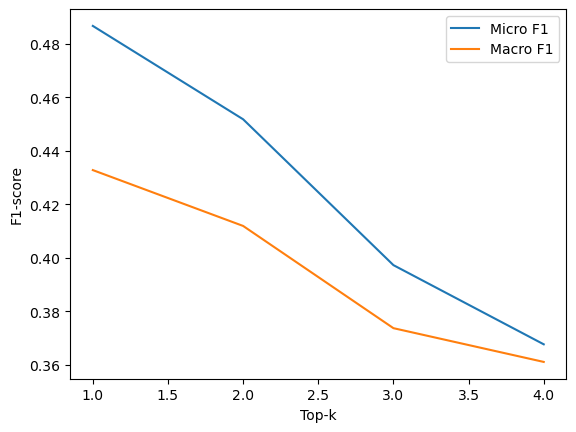

In [43]:
plt.plot(topks, micros, label = 'Micro F1')
plt.plot(topks, macros, label = 'Macro F1')
plt.xlabel('Top-k')
plt.ylabel('F1-score')
plt.legend(loc='best')
plt.show()

샘플당 점수가 가장 높은 레이블을 선택하는 방식이 최상의 결과를 냈다.

In [44]:
# 샘플당 하나 이상의 레이블 예측할 수 있으므로 임계값 방식과 비교
macros, micros = [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds :
    ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'threshold':threshold})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report['micro avg']['f1-score'])
    macros.append(clf_report['macro avg']['f1-score'])

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

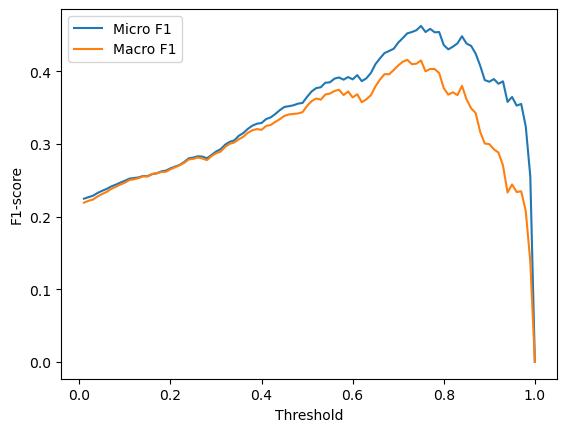

In [45]:
plt.plot(thresholds, micros, label = 'Micro F1')
plt.plot(thresholds, macros, label = 'Macro F1')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.legend(loc='best')
plt.show()

In [46]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'최상의 임곗값 (마이크로):{best_t}, F1-score {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'최상의 임곗값 (매크로):{best_t}, F1-score {best_macro:.2f}.')

최상의 임곗값 (마이크로):0.75, F1-score 0.46.
최상의 임곗값 (매크로):0.72, F1-score 0.42.


탑-1 결과보다 나쁘지만, 그래프에 정밀도/재현율의 트레이드오프가 확실하게 나타난다.  
임계값을 매우 낮게 설정하면 예측이 매우 많아져 정밀도가 낮아진다.   
임계값을 매우 높게 하면 예측하기 어려워져 재현율이 낮아진다.

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

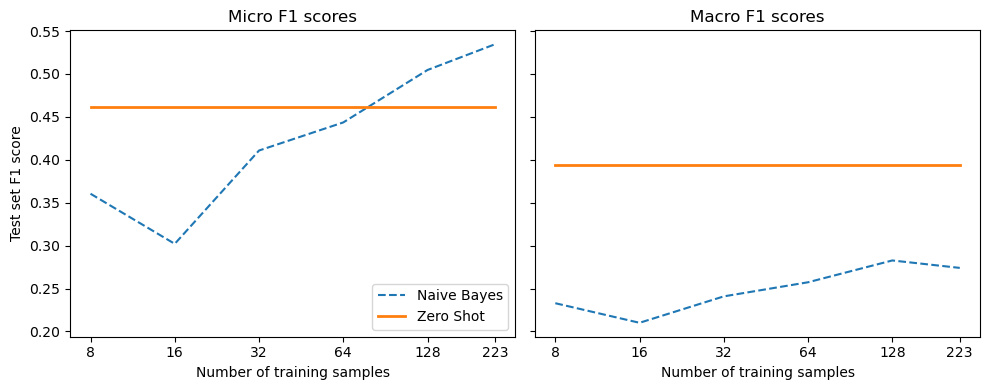

In [47]:
# 탑-1 사용해 테스트셋에서 제로샷 분류와 나이브 베이즈 비교
ds_zero_shot = ds['test'].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'topk':1})
clf_report = get_clf_report(ds_zero_shot)

for train_slice in train_slices :
    macro_scores['Zero Shot'].append(clf_report['macro avg']['f1-score'])
    micro_scores['Zero Shot'].append(clf_report['micro avg']['f1-score'])
    
plot_metrics(micro_scores, macro_scores, train_samples, 'Zero Shot')

- 레이블링된 샘플이 50개보다 적다면 제로샷 파이프라인이 기준 모델의 성능을 쉽게 추월함
- 샘플이 50개 이상이더라도 마이크로와 매크로 F1-score 모두 고려하면, 제로샷 파이프라인이 더 낫다. 마이크로 F1-score 결과를 보면, 기준 모델이 빈도가 높은 클래스에서 잘 동작하지만, 제로샷 파이프라인은 학습할 샘플이 피요하지 않기에 기준 모델보다 뛰어나다.


### 레이블링된 데이터가 적은 경우
* 데이터 증식
    * 역 번역 : 원본 언어로 된 텍스트를 기계 번역 사용해 하나 이상의 타깃 언어로 번역한 후 원본 언어로 다시 번역
        * 데이터가 많은 언어 또는 도메인 특화된 언어가 매우 많지 않은 말뭉치에서 잘 동작함
    * 토큰 섞기 : 훈련셋의 한 텍스트에서 동의어 교체, 단어 추가, 교환, 삭제 같은 간단한 변환을 임의로 선택해 수행

In [50]:
# 동의어 교체
from transformers import set_seed
import nlpaug.augmenter.word as naw

set_seed(3)
aug = naw.ContextualWordEmbsAug(model_path = 'distilbert-base-uncased', action='substitute')
text = 'Transformers are the most popular toys'
print(f"원본텍스트 : {text}")
print(f"증식된 텍스트 : {aug.augment(text)}")

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


원본텍스트 : Transformers are the most popular toys
증식된 텍스트 : ['transformers get the most interesting toys']


In [51]:
def augment_text(batch, transformations_per_example=1):
    text_aug, label_ids = [], []
    for text, labels in zip(batch["text"], batch["label_ids"]):
        text_aug += [text]
        label_ids += [labels]
        for _ in range(transformations_per_example):
            text_aug += aug.augment(text)
            label_ids += [labels]
    return {"text": text_aug, "label_ids": label_ids}

In [ ]:
for train_slice in train_slices:
    ds_train_sample = ds["train"].select(train_slice)
    
    # 증식 결과를 펼쳐 레이블에 정렬
    ds_train_aug = (ds_train_sample.map(
        augment_text, batched=True, remove_columns=ds_train_sample.column_names)
                    .shuffle(seed=42))
    y_train = np.array(ds_train_aug["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    
    # 간단한 CountVectorizer를 사용해 텍스트를 토큰 카운트로 인코딩
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_aug["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])

    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)

    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)

    macro_scores["Naive Bayes + Aug"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes + Aug"].append(clf_report["micro avg"]["f1-score"])

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes + Aug")

데이터 증식으로 나이브 베이즈 분류기의 점수 상승

* 임베딩을 룩업 테이블로 사용하기
    * 언어 모델을 사용해 레이블링된 전체 텍스트 임베딩
    * 저장된 임베딩에 최근접 이웃 검색 수행
    * 최근접 이웃의 레이블을 수집해 예측 만듦

새로운 텍스트 분류할 때 이를 임베딩한 후 최근접 이웃의 레이블 기반으로 새로운 텍스트의 레이블 부여 - 레이블링된 데이터 포인트를 활용하기 위해 모델 미세 튜닝할 필요 X

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

model_ckpt = "miguelvictor/python-gpt2-medium"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

def mean_pooling(model_output, attention_mask):
    # 토큰 임베딩 추출하기
    token_embeddings = model_output[0]
    # 어텐션 마스크 계산하기
    input_mask_expanded = (attention_mask
                           .unsqueeze(-1)
                           .expand(token_embeddings.size())
                           .float())
    # 임베딩을 더하지만 마스킹된 토큰은 무시
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    # 하나의 벡터로 평균 반환
    return sum_embeddings / sum_mask

def embed_text(examples):
    inputs = tokenizer(examples["text"], padding=True, truncation=True,
                       max_length=128, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

In [ ]:
# GPT는 패딩 토큰이 없으므로 배치형식으로 임베딩을 구현하려면 패딩 토큰 추가해야
# EOS 토큰 재사용
tokenizer.pad_token = tokenizer.eos_token
embs_train = ds["train"].map(embed_text, batched=True, batch_size=16)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=16)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=16)

In [ ]:
embs_train.add_faiss_index("embedding")

In [ ]:
i, k = 0, 3     # 첫 번째 쿼리와 3개의 최근접 이웃 선택
rn, nl = "\r\n\r\n", "\n"   # 간결한 출력을 위해 텍스트에서 줄바꿈 문자 삭제

query =  np.array(embs_valid[i]["embedding"], dtype=np.float32)
scores, samples = embs_train.get_nearest_examples("embedding", query, k=k)

print(f"쿼리 레이블: {embs_valid[i]['labels']}")
print(f"쿼리 텍스트:\n{embs_valid[i]['text'][:200].replace(rn, nl)} [...]\n")
print("="*50)
print(f"추출된 문서:")
for score, label, text in zip(scores, samples["labels"], samples["text"]):
    print("="*50)
    print(f"텍스트:\n{text[:200].replace(rn, nl)} [...]")
    print(f"점수: {score:.2f}")
    print(f"레이블: {label}")

In [ ]:
# 검증셋에 있는 각 샘플엣 반복하지 않고 쿼리 배치 받음
def get_sample_preds(sample, m):
    return (np.sum(sample["label_ids"], axis=0) >= m).astype(int)

def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=17):
    max_k = min(len(ds_train), max_k)
    perf_micro = np.zeros((max_k, max_k))
    perf_macro = np.zeros((max_k, max_k))
    for k in range(1, max_k):
        for m in range(1, k + 1):
            _, samples = ds_train.get_nearest_examples_batch("embedding",
                                                             valid_queries, k=k)
            y_pred = np.array([get_sample_preds(s, m) for s in samples])
            clf_report = classification_report(valid_labels, y_pred,
                target_names=mlb.classes_, zero_division=0, output_dict=True)
            perf_micro[k, m] = clf_report["micro avg"]["f1-score"]
            perf_macro[k, m] = clf_report["macro avg"]["f1-score"]
    return perf_micro, perf_macro

In [ ]:
valid_labels = np.array(embs_valid["label_ids"])
valid_queries = np.array(embs_valid["embedding"], dtype=np.float32)
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels)

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro)

ax0.set_title("micro scores")
ax0.set_ylabel("k")
ax1.set_title("macro scores")
for ax in [ax0, ax1]:
    ax.set_xlim([0.5, 17 - 0.5])
    ax.set_ylim([17 - 0.5, 0.5])
    ax.set_xlabel("m")
plt.show()